### Connect to Drive

In [66]:
#from google.colab import drive
#drive.mount('/gdrive')

In [67]:
#%cd /gdrive/My Drive/ANN Exercises/Homework1

### Import libraries

In [68]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [69]:
# Import dataset
#!unzip training_dataset_homework1.zip

# Dataset folders 
dataset_dir = '../input/homework1/training_data_final'

In [70]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [71]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

In [72]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_train_data_gen = ImageDataGenerator(rotation_range=20, 
                                        fill_mode='reflect',
                                        #height_shift_range=20,
                                        #width_shift_range=10,
                                        brightness_range=[0.7,1.2],
                                        zoom_range=0.3,
                                        vertical_flip=True,
                                        horizontal_flip=True,
                                        validation_split=0.2
                                       )

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="training",
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

no_aug_data_gen = ImageDataGenerator(validation_split=0.2)

train_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=labels, # can be set to labels
                                                subset="training",
                                                class_mode='categorical',
                                                batch_size=8,
                                                shuffle=True,
                                                seed=seed)

valid_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=labels, # can be set to labels
                                                subset="validation",
                                                class_mode='categorical',
                                                batch_size=8,
                                                shuffle=False,
                                                seed=seed)

Found 2836 images belonging to 8 classes.
Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [73]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [74]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]
    
    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    
    #image = image*255
    
    plt.imshow(np.uint8(image))

    return batch

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2


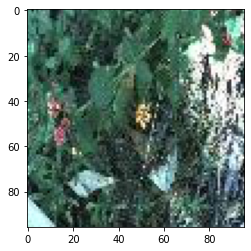

In [75]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

### Models metadata

In [76]:
input_shape = (96, 96, 3)
epochs = 200

### CNN model

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
__________________________

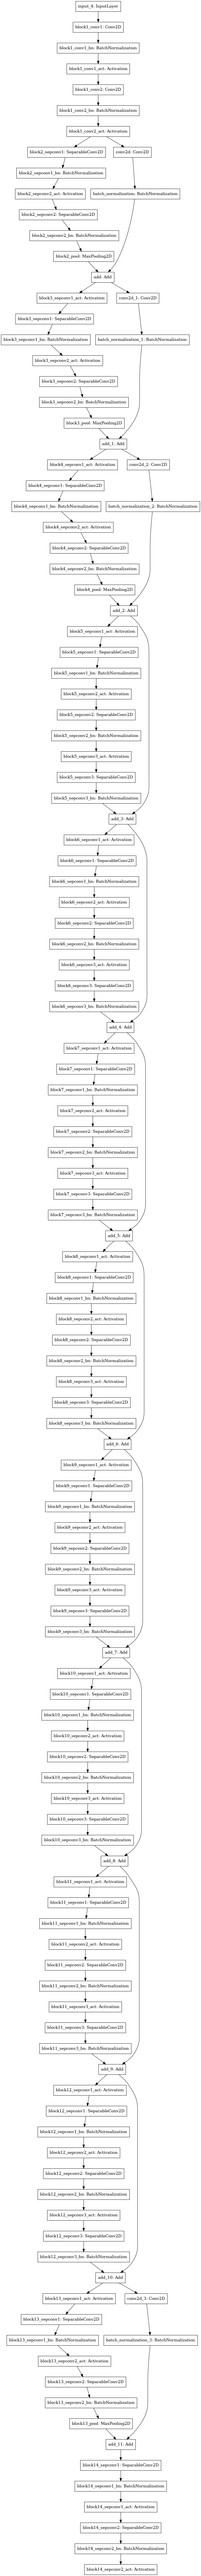

In [77]:
# Download and plot the VGG16 model
supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

# Use the supernet as feature extractor
supernet.trainable = False

supernet.summary()
tfk.utils.plot_model(supernet)

In [88]:
inputs = tfk.Input(shape=input_shape)
x = tfk.applications.xception.preprocess_input(inputs)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-4), metrics='accuracy')

tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
Flattening (GlobalAveragePoo (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               524544

In [89]:
# Set all VGG layers to True
tl_model.get_layer('xception').trainable = True
for i, layer in enumerate(tl_model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)

0 input_4 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [90]:
# Freeze first N layers, e.g., until 14th
#for i, layer in enumerate(tl_model.get_layer('xception').layers[:14]):
#    layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)
    
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
tl_model.summary()

0 input_4 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [91]:
# Train the model
history = tl_model.fit(
    x = aug_train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
).history

Epoch 1/200
355/355 [==============================] - 22s 49ms/step - loss: 1.9170 - accuracy: 0.2539 - val_loss: 3.7282 - val_accuracy: 0.4051
Epoch 2/200
355/355 [==============================] - 17s 47ms/step - loss: 1.5116 - accuracy: 0.4640 - val_loss: 1.4535 - val_accuracy: 0.6076
Epoch 3/200
355/355 [==============================] - 16s 46ms/step - loss: 1.2931 - accuracy: 0.5427 - val_loss: 6.1871 - val_accuracy: 0.5765
Epoch 4/200
355/355 [==============================] - 17s 47ms/step - loss: 1.1680 - accuracy: 0.5913 - val_loss: 4.1225 - val_accuracy: 0.5652
Epoch 5/200
355/355 [==============================] - 16s 46ms/step - loss: 1.0781 - accuracy: 0.6315 - val_loss: 2.1133 - val_accuracy: 0.6317
Epoch 6/200
355/355 [==============================] - 17s 47ms/step - loss: 1.0025 - accuracy: 0.6604 - val_loss: 3.0919 - val_accuracy: 0.6402
Epoch 7/200
355/355 [==============================] - 16s 46ms/step - loss: 0.9331 - accuracy: 0.6830 - val_loss: 4.6384 - val_ac

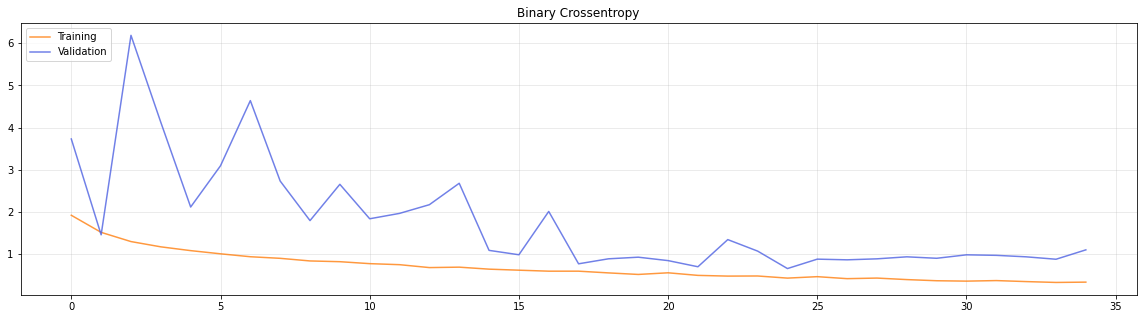

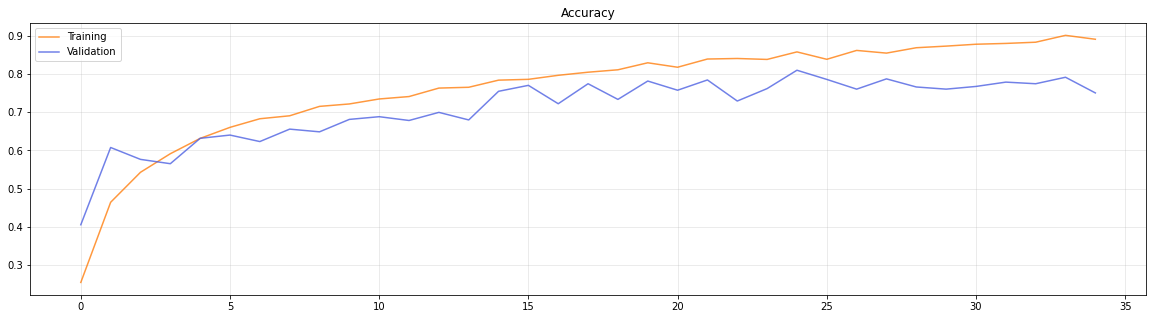

In [92]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [93]:
# Use the supernet as feature extractor
supernet.trainable = False

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
Flattening (GlobalAveragePoo (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               524544

In [94]:
# Fine-tune the model
ft_history = tl_model.fit(
    x = train_gen,
    batch_size = 8,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
355/355 [==============================] - 10s 20ms/step - loss: 0.1837 - accuracy: 0.9436 - val_loss: 0.5900 - val_accuracy: 0.8428
Epoch 2/200
355/355 [==============================] - 6s 17ms/step - loss: 0.1425 - accuracy: 0.9520 - val_loss: 0.5800 - val_accuracy: 0.8584
Epoch 3/200
355/355 [==============================] - 6s 16ms/step - loss: 0.1318 - accuracy: 0.9577 - val_loss: 0.5765 - val_accuracy: 0.8598
Epoch 4/200
355/355 [==============================] - 6s 16ms/step - loss: 0.1172 - accuracy: 0.9598 - val_loss: 0.5742 - val_accuracy: 0.8598
Epoch 5/200
355/355 [==============================] - 6s 16ms/step - loss: 0.1279 - accuracy: 0.9580 - val_loss: 0.5741 - val_accuracy: 0.8612
Epoch 6/200
355/355 [==============================] - 6s 17ms/step - loss: 0.1150 - accuracy: 0.9594 - val_loss: 0.5940 - val_accuracy: 0.8569
Epoch 7/200
355/355 [==============================] - 7s 18ms/step - loss: 0.1054 - accuracy: 0.9665 - val_loss: 0.5819 - val_accuracy

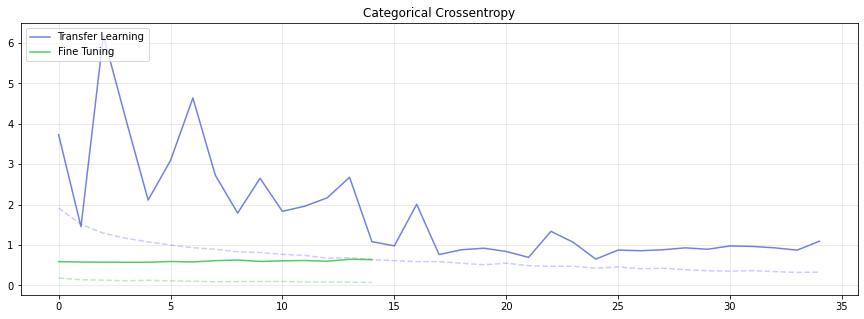

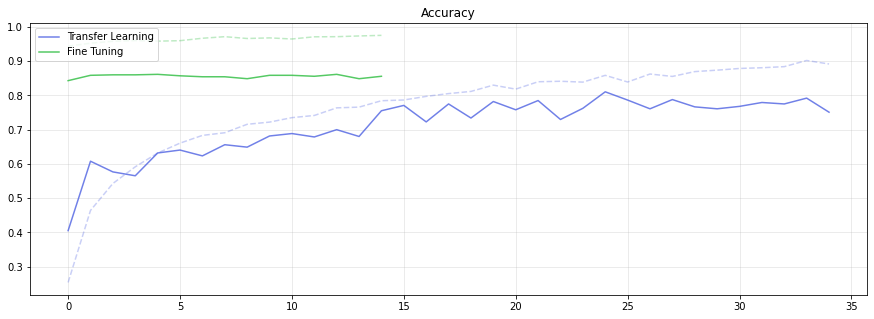

In [95]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [96]:
from sklearn.metrics import classification_report

def evaluate_classes_performance(model, validation_dataset):

    data_list = []
    label_list = []
    batch_index = 0

    while batch_index <= validation_dataset.batch_index:
        data = validation_dataset.next()

        for i in range(len(data[0])):
            data_list.append(data[0][i])
            label_list.append(data[1][i])

        batch_index = batch_index + 1

    data_array = np.array(data_list)
    label_array = np.array(label_list)   
    label_values = np.argmax(label_array, axis=1)
    predictions = tl_model.predict(data_array)
    predictions = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions)
    print(report)

In [97]:
evaluate_classes_performance(tl_model, valid_gen)

              precision    recall  f1-score   support

           0       0.52      0.46      0.49        37
           1       0.91      0.91      0.91       106
           2       0.84      0.94      0.89       103
           3       0.87      0.82      0.84       102
           4       0.88      0.85      0.87       106
           5       0.92      0.82      0.87        44
           6       0.93      0.98      0.95       107
           7       0.82      0.82      0.82       101

    accuracy                           0.86       706
   macro avg       0.84      0.83      0.83       706
weighted avg       0.86      0.86      0.86       706



In [98]:
tl_model.save('ANN_Homework1_Model')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [99]:
import shutil
tl_model.save('ANN_Homework1_Model')
shutil.make_archive("ANN_Homework1_Model", 'zip', '/kaggle/working/ANN_Homework1_Model')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


'/kaggle/working/ANN_Homework1_Model.zip'

In [100]:
tl_model.get_layer('vgg16').trainable = False

ValueError: No such layer: vgg16.

In [ ]:
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
tl_model.summary()